In [25]:
# Imports and helper utilities
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

DATA_PATH = Path().cwd().parent / 'data' / 'shipments.csv'
df = pd.read_csv(DATA_PATH, parse_dates=['ship_date','eta_date'], low_memory=False)
pucharse_df = pd.read_csv(Path().cwd().parent / 'data' / 'purchase_orders.csv', parse_dates=['order_date', "promised_date"], low_memory=False)
suppliers_df = pd.read_csv(Path().cwd().parent / 'data' / 'suppliers.csv', low_memory=False,
                           )
sku_df = pd.read_csv(Path().cwd().parent / 'data' / 'skus.csv', low_memory=False)
transit_events = pd.read_csv(Path().cwd().parent / 'data' / 'transit_events.csv', parse_dates=['event_ts'], low_memory=False ) # shipment_id,event_ts,location_type,event_status                     
# get last evenet for every unique shipment_id
last_events = transit_events[transit_events['event_status'].isin(['Delivered'])]
last_events = last_events[last_events['location_type'].isin(['Destination'])] # DC - distribution center
last_events = last_events.sort_values('event_ts').groupby('shipment_id').tail(1)
# filter by only status = Delivered and destination = `Destination`

# merge last event status to df
df = df.merge(
    last_events[['shipment_id', 'event_ts']],
    on='shipment_id',
    how='left'
)
# event_ts -> actual_delivery_date
df.rename(columns={'event_ts': 'actual_delivery_date'}, inplace=True)

df = df.merge(
    pucharse_df[['po_id', 'supplier_id', 'country','sku_id', 'order_date', 'promised_date', 'unit_price_usd']],
    on='po_id',
    how='left'
)
# df country = destination_country 
df.rename(columns={'country': 'destination_country'}, inplace=True)
# ,order_date,promised_date -> promised_days
df['promised_days'] = (df['promised_date'] - df['order_date']).dt.days
# df.drop(columns=['order_date', 'promised_date'], inplace=True)

df = df.merge(
    suppliers_df[['supplier_id','country', 'on_time_performance', 'iso_certified']],
    on='supplier_id',
    how='left'
)
df.rename(columns={'country': 'supplier_country'}, inplace=True)



# sku_id,vendor,category,technology,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days
# SKU-00001,Juniper,Cabling,5G,11.01,0.1236,360.72,27
# SKU-00002,ZTE,Power,5G,8.82,0.098,965.54,81
df = df.merge(
    sku_df[['sku_id', 'technology', 'unit_weight_kg', 'unit_volume_m3', 'std_cost_usd', 'supplier_nominal_lead_time_days']],
    on='sku_id',
    how='left'    
)
# drop all fields that end wit `_id`
df

,shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,...,unit_price_usd,promised_days,supplier_country,on_time_performance,iso_certified,technology,unit_weight_kg,unit_volume_m3,std_cost_usd,supplier_nominal_lead_time_days
0,SH-00000001,PO-0104861,6,Road,CIF,Mexico,ST-00452,2025-02-03,2025-02-10,Delivered,...,254.94,30,UK,0.974,True,Dual (4G/5G),9.86,0.1112,251.64,82
1,SH-00000002,PO-0099598,3,Sea,EXW,India,ST-00086,2024-08-21,2024-09-27,Delayed,...,180.57,18,Germany,0.842,True,4G,22.27,0.2260,169.04,83
2,SH-00000003,PO-0110843,8,Road,FOB,Italy,ST-00252,2023-01-21,2023-01-30,In Transit,...,606.62,16,Mexico,0.835,True,4G,30.12,0.3110,536.85,62
3,SH-00000004,PO-0047627,6,Sea,FOB,Argentina,ST-00800,2023-07-03,2023-08-05,In Transit,...,345.47,35,Colombia,0.836,True,5G,12.38,0.1376,328.45,27
4,SH-00000005,PO-0003236,6,Road,DAP,Brazil,ST-01995,2025-06-19,2025-06-27,Delivered,...,1083.48,26,Singapore,0.859,True,5G,7.68,0.0868,979.73,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217495,SH-00217496,PO-0033886,2,Road,EXW,Argentina,ST-01757,2023-09-30,2023-10-07,In Transit,...,602.24,27,Singapore,0.965,False,4G,31.80,0.3224,576.73,8
217496,SH-00217497,PO-0038120,7,Road,EXW,Mexico,ST-01876,2024-08-14,2024-08-27,Delivered,...,165.72,24,USA,0.946,True,5G,16.08,0.1691,169.84,5
217497,SH-00217498,PO-0079713,3,Air,DAP,Spain,ST-01330,2023-12-25,2024-01-02,In Transit,...,821.15,43,France,0.921,True,5G,31.14,0.3277,708.08,35
217498,SH-00217499,PO-0044911,4,Air,FOB,Brazil,ST-01986,2025-02-24,2025-03-05,Delivered,...,365.32,30,Brazil,0.771,False,5G,42.53,0.4315,306.04,38


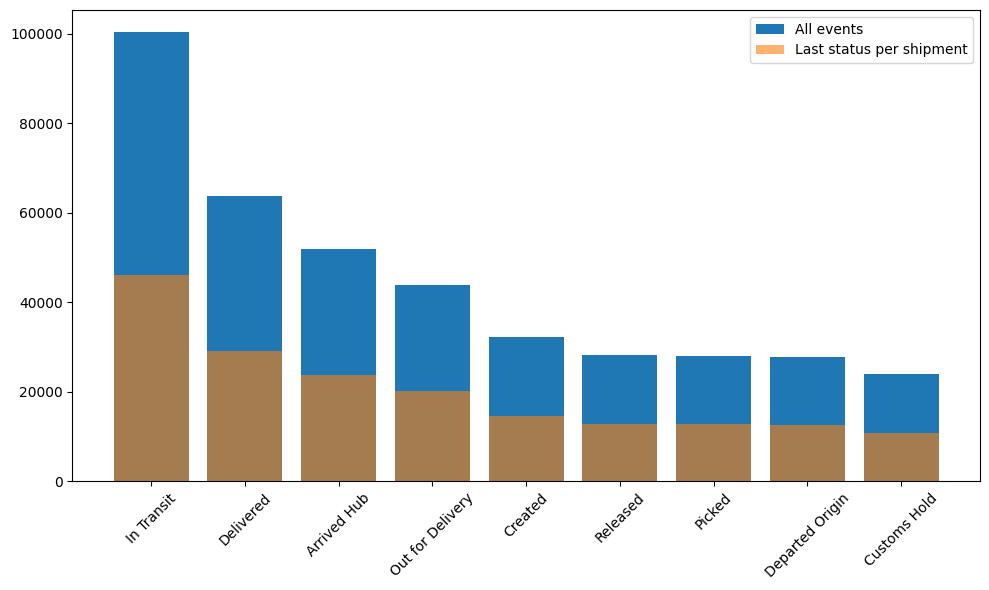

In [26]:
# check last status of shipments (there are multiple statuses for every shipment)
last_status = transit_events.sort_values('event_ts').groupby('shipment_id').tail(1)[['shipment_id', 'event_status']]
last_status['event_status'].value_counts()
# # all statuses count
statuses = transit_events['event_status'].value_counts()
statuses
# plot all events vs last status per shipment with aligned labels
labels = statuses.index.tolist()
all_counts = statuses.reindex(labels).values
last_counts = last_status['event_status'].value_counts().reindex(labels, fill_value=0).values

x = np.arange(len(labels))
plt.figure(figsize=(10,6))
plt.bar(x, all_counts, label='All events', color='C0')
plt.bar(x, last_counts, alpha=0.6, label='Last status per shipment', color='C1')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()

In [27]:
# drop most *_id columns but keep shipment- and supplier-level identifiers
protected_ids = {'shipment_id', 'supplier_id', 'sku_id'}
cols_to_drop = [
    col for col in df.columns
    if col.endswith('_id') and col not in protected_ids
]
df.drop(columns=cols_to_drop, inplace=True)


In [28]:
# count `actual_delivery_date` < `order_date`  (should not happen)
invalid_deliveries = df[df['actual_delivery_date'] < df['order_date']]
print(f"Invalid deliveries count: {len(invalid_deliveries)}")
# count shippmenet status delivered but no actual_delivery_date
delivered_no_date = df[(df['status'].isin(['Delivered', 'Delayed'])) & (df['actual_delivery_date'].isna())]
print(f"Delivered shipments with no actual delivery date: {len(delivered_no_date)}")
# count shipment status not delivered but has actual_delivery_date
not_delivered_with_date = df[(~df['status'].isin(['Delivered', 'Delayed'])) & (~df['actual_delivery_date'].isna())]
print(f"Not delivered shipments with actual delivery date: {len(not_delivered_with_date)}")
df.shape

Invalid deliveries count: 3380
Delivered shipments with no actual delivery date: 92991
Not delivered shipments with actual delivery date: 3888


(217500, 24)

In [29]:
# keep only items with `Delivered` and `Delayed` status and clean obvious data issues
model_df = df[df['status'].isin(['Delivered', 'Delayed'])].copy()

required_cols = ['ship_date', 'eta_date', 'promised_date', 'order_date', 'actual_delivery_date']
model_df = model_df.dropna(subset=required_cols)
model_df = model_df[
    (model_df['actual_delivery_date'] >= model_df['ship_date']) &
    (model_df['actual_delivery_date'] >= model_df['order_date'])
]

print(f"Modeling rows after cleaning: {len(model_df):,}")
print(f"Delayed share inside modeling set: {model_df['status'].eq('Delayed').mean():.2%}")


Modeling rows after cleaning: 1,078
Delayed share inside modeling set: 10.67%


Text(0.5, 1.0, 'Correlation across engineered lateness features')

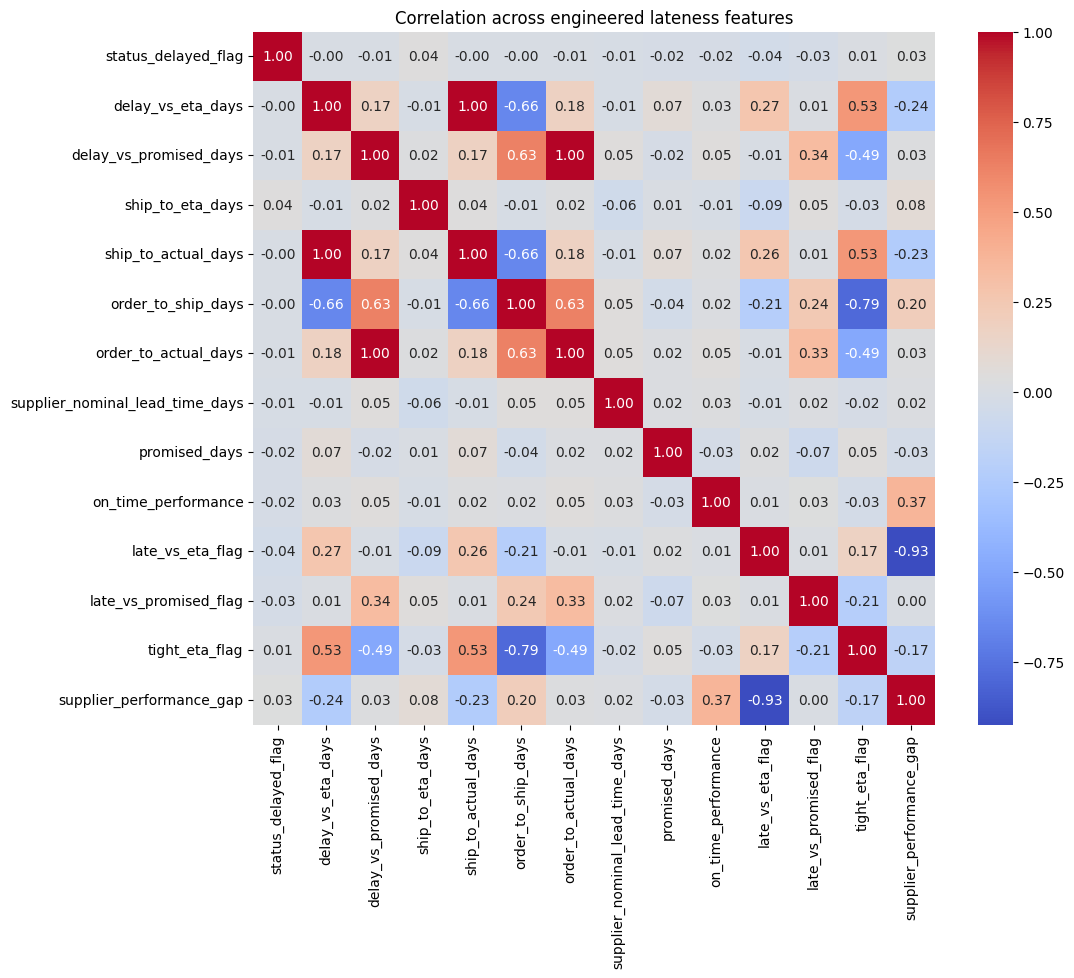

In [30]:
# feature engineering for lateness indicators
model_df['delay_vs_eta_days'] = (model_df['actual_delivery_date'] - model_df['eta_date']).dt.days
model_df['delay_vs_promised_days'] = (model_df['actual_delivery_date'] - model_df['promised_date']).dt.days
model_df['ship_to_eta_days'] = (model_df['eta_date'] - model_df['ship_date']).dt.days
model_df['ship_to_actual_days'] = (model_df['actual_delivery_date'] - model_df['ship_date']).dt.days
model_df['order_to_ship_days'] = (model_df['ship_date'] - model_df['order_date']).dt.days
model_df['order_to_actual_days'] = (model_df['actual_delivery_date'] - model_df['order_date']).dt.days
model_df['eta_vs_promised_days'] = (model_df['eta_date'] - model_df['promised_date']).dt.days
model_df['status_delayed_flag'] = (model_df['status'] == 'Delayed').astype(int)

model_df['late_vs_eta_flag'] = (model_df['delay_vs_eta_days'] > 0).astype(int)
model_df['late_vs_promised_flag'] = (model_df['delay_vs_promised_days'] > 0).astype(int)
model_df['tight_eta_flag'] = (model_df['eta_vs_promised_days'] < 0).astype(int)
model_df['supplier_performance_gap'] = model_df['on_time_performance'] - model_df['late_vs_eta_flag']

lateness_cols = [
    'status_delayed_flag',
    'delay_vs_eta_days',
    'delay_vs_promised_days',
    'ship_to_eta_days',
    'ship_to_actual_days',
    'order_to_ship_days',
    'order_to_actual_days',
    'supplier_nominal_lead_time_days',
    'promised_days',
    'on_time_performance',
    'late_vs_eta_flag',
    'late_vs_promised_flag',
    'tight_eta_flag',
    'supplier_performance_gap'
]

corr = model_df[lateness_cols].corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation across engineered lateness features')

In [31]:
# rank numeric features by correlation with the delay flag
numeric_corr = model_df.corr(numeric_only=True)['status_delayed_flag'].drop('status_delayed_flag')
print(numeric_corr.sort_values(ascending=False).head(10))
print('\nLeast correlated features:')
print(numeric_corr.sort_values().head(10))

unit_weight_kg              0.044163
unit_volume_m3              0.044018
ship_to_eta_days            0.040240
supplier_performance_gap    0.033501
std_cost_usd                0.011582
tight_eta_flag              0.010891
unit_price_usd              0.005753
iso_certified              -0.000184
ship_to_actual_days        -0.000832
eta_vs_promised_days       -0.002489
Name: status_delayed_flag, dtype: float64

Least correlated features:
late_vs_eta_flag                  -0.043254
late_vs_promised_flag             -0.029124
on_time_performance               -0.017540
promised_days                     -0.017526
supplier_nominal_lead_time_days   -0.014772
ship_qty                          -0.010276
order_to_actual_days              -0.006816
delay_vs_promised_days            -0.006123
order_to_ship_days                -0.004568
delay_vs_eta_days                 -0.002785
Name: status_delayed_flag, dtype: float64


In [32]:
# select categorical features CatBoost should treat as categories
cat_candidates = model_df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_candidates = [col for col in cat_candidates if col not in {'status', 'shipment_id'}]

max_unique = 500
force_keep = {'supplier_id', 'sku_id', 'origin_country', 'destination_country', 'mode', 'incoterm', 'technology'}
categorical_feats = [
    col for col in cat_candidates
    if model_df[col].nunique() <= max_unique or col in force_keep
]
categorical_feats = sorted(set(categorical_feats))
print(f"Categorical features ({len(categorical_feats)}): {categorical_feats}")
categorical_feats

Categorical features (8): ['destination_country', 'incoterm', 'mode', 'origin_country', 'sku_id', 'supplier_country', 'supplier_id', 'technology']


['destination_country',
 'incoterm',
 'mode',
 'origin_country',
 'sku_id',
 'supplier_country',
 'supplier_id',
 'technology']

In [33]:
# collect feature set for modeling
numeric_features = model_df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['status_delayed_flag']]

model_features = numeric_features + categorical_feats
print(f"Using {len(model_features)} features: {len(numeric_features)} numeric + {len(categorical_feats)} categorical")
model_features

Using 27 features: 19 numeric + 8 categorical


['ship_qty',
 'unit_price_usd',
 'promised_days',
 'on_time_performance',
 'unit_weight_kg',
 'unit_volume_m3',
 'std_cost_usd',
 'supplier_nominal_lead_time_days',
 'delay_vs_eta_days',
 'delay_vs_promised_days',
 'ship_to_eta_days',
 'ship_to_actual_days',
 'order_to_ship_days',
 'order_to_actual_days',
 'eta_vs_promised_days',
 'late_vs_eta_flag',
 'late_vs_promised_flag',
 'tight_eta_flag',
 'supplier_performance_gap',
 'destination_country',
 'incoterm',
 'mode',
 'origin_country',
 'sku_id',
 'supplier_country',
 'supplier_id',
 'technology']

In [34]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


X = model_df[model_features]
y = model_df['status_delayed_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

cat_feature_indices = [model_features.index(col) for col in categorical_feats]
class_weights = [1.0, (y_train == 0).mean() / (y_train == 1).mean()]

cat_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.03,
    l2_leaf_reg=5,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    class_weights=class_weights,
    od_type='Iter',
    od_wait=50,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    colsample_bylevel=0.8
)
cat_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_feature_indices,
    use_best_model=True
)

print(
    f"Best iteration: {cat_model.get_best_iteration()} | "
    f"Validation AUC: {cat_model.get_best_score()['validation']['AUC']:.3f}"
)

y_proba = cat_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print(f"Historical delay probability: {y.mean():.2%}")
print(classification_report(y_test, y_pred, target_names=['Delivered', 'Delayed']))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=['Actual Delivered', 'Actual Delayed'],
    columns=['Pred Delivered', 'Pred Delayed']
)
cm

feature_importances = pd.Series(cat_model.get_feature_importance(), index=model_features)
feature_importances.sort_values(ascending=False).head(15)

0:	test: 0.4766839	best: 0.4766839 (0)	total: 242ms	remaining: 4m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5786213111
bestIteration = 5

Shrink model to first 6 iterations.
Best iteration: 5 | Validation AUC: 0.579
Historical delay probability: 10.67%
              precision    recall  f1-score   support

   Delivered       0.90      0.63      0.74       193
     Delayed       0.12      0.43      0.19        23

    accuracy                           0.61       216
   macro avg       0.51      0.53      0.47       216
weighted avg       0.82      0.61      0.69       216

Test ROC AUC: 0.579


unit_volume_m3              15.226186
ship_to_eta_days            12.908003
incoterm                    10.395497
eta_vs_promised_days         9.259878
origin_country               8.135327
delay_vs_promised_days       7.351771
technology                   6.878955
destination_country          5.827510
promised_days                5.245202
order_to_ship_days           5.155347
late_vs_eta_flag             4.311808
ship_to_actual_days          2.932514
supplier_country             2.491056
supplier_performance_gap     2.300488
mode                         0.938680
dtype: float64

In [35]:
# inspect predicted probabilities for a handful of hold-out shipments
results_cols = ['shipment_id', 'status', 'delay_vs_eta_days', 'delay_vs_promised_days', 'ship_to_actual_days']
test_results = (
    model_df.loc[X_test.index, results_cols]
    .assign(
        predicted_delay_probability=y_proba,
        predicted_label=np.where(y_pred == 1, 'Delayed', 'Delivered')
    )
    .sort_values('predicted_delay_probability', ascending=False)
)
test_results.head(10)


,shipment_id,status,delay_vs_eta_days,delay_vs_promised_days,ship_to_actual_days,predicted_delay_probability,predicted_label
96843,SH-00096844,Delivered,819,546,828,0.511970,Delayed
196432,SH-00196433,Delivered,-5,55,26,0.511701,Delayed
99854,SH-00099855,Delivered,-2,112,8,0.510683,Delayed
72494,SH-00072495,Delivered,601,723,608,0.510359,Delayed
152218,SH-00152219,Delivered,99,119,102,0.509649,Delayed
20886,SH-00020887,Delayed,-6,-7,2,0.508276,Delayed
122231,SH-00122232,Delivered,727,242,762,0.507919,Delayed
67952,SH-00067953,Delayed,368,220,405,0.507551,Delayed
78519,SH-00078520,Delivered,449,170,456,0.507484,Delayed
152754,SH-00152755,Delivered,441,83,451,0.507484,Delayed


In [36]:
def predict_delay_probability(shipment_ids):
    """Return predicted delay probability for given shipment ids."""
    subset = model_df[model_df['shipment_id'].isin(shipment_ids)].copy()
    if subset.empty:
        raise ValueError("No matching shipments found for supplied IDs")
    probs = cat_model.predict_proba(subset[model_features])[:, 1]
    subset = subset[['shipment_id', 'status', 'delay_vs_eta_days', 'ship_to_actual_days']]
    subset['predicted_delay_probability'] = probs
    return subset.sort_values('predicted_delay_probability', ascending=False)

# example: score the top 5 riskiest shipments from the hold-out sample
predict_delay_probability(test_results.head(5)['shipment_id'].tolist())


,shipment_id,status,delay_vs_eta_days,ship_to_actual_days,predicted_delay_probability
96843,SH-00096844,Delivered,819,828,0.511970
196432,SH-00196433,Delivered,-5,26,0.511701
99854,SH-00099855,Delivered,-2,8,0.510683
72494,SH-00072495,Delivered,601,608,0.510359
152218,SH-00152219,Delivered,99,102,0.509649
